# Rapport de laboratoire 3

## Exercice 1

In [13]:
using LinearAlgebra, NLPModels, Printf, ADNLPModels, LinearOperators, SolverCore

In [14]:
function armijo(xk, dk, fk, gk, slope, nlp :: AbstractNLPModel; τ1 = 1.0e-4, t_update = 1.5)
    t = 1.0
    fk_new = obj(nlp, xk + dk) # t = 1.0
    while fk_new > fk + τ1 * t * slope
      t /= t_update
      fk_new = obj(nlp, xk + t * dk)
    end
    return t, fk_new
  end

armijo (generic function with 1 method)

In [15]:
function limited_bfgs(nlp      :: AbstractNLPModel;
    x        :: AbstractVector = nlp.meta.x0,
    atol     :: Real = √eps(eltype(x)), 
    rtol     :: Real = √eps(eltype(x)),
    max_eval :: Int = -1,
    max_time :: Float64 = 30.0,
    f_min    :: Float64 = -1.0e16,
    verbose  :: Bool = true,
    mem      :: Int = 5)
start_time = time()
elapsed_time = 0.0

T = eltype(x)
n = nlp.meta.nvar

xt = zeros(T, n)
∇ft = zeros(T, n)

f = obj(nlp, x)
∇f = grad(nlp, x)
#################################################
H = InverseLBFGSOperator(n; mem=mem)
#################################################

∇fNorm = norm(∇f) #nrm2(n, ∇f)
ϵ = atol + rtol * ∇fNorm
iter = 0

@info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
 hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

optimal = ∇fNorm ≤ ϵ
unbdd = f ≤ f_min
tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
stalled = false
status = :unknown

while !(optimal || tired || stalled || unbdd)
#################################################
d = - H * ∇f
#################################################
slope = dot(d, ∇f)
if slope ≥ 0
@error "not a descent direction" slope
status = :not_desc
stalled = true
continue
end

# Perform improved Armijo linesearch.
t, ft = armijo(x, d, f, ∇f, slope, nlp)

@info log_row(Any[iter, f, ∇fNorm, slope, t])

# Update L-BFGS approximation.
xt = x + t * d
∇ft = grad(nlp, xt) # grad!(nlp, xt, ∇ft)
#################################################
push!(H, xt - x, ∇ft - ∇f)
#################################################

# Move on.
x = xt
f = ft
∇f = ∇ft

∇fNorm = norm(∇f) #nrm2(n, ∇f)
iter = iter + 1

optimal = ∇fNorm ≤ ϵ
unbdd = f ≤ f_min
elapsed_time = time() - start_time
tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
end
@info log_row(Any[iter, f, ∇fNorm])

if optimal
status = :first_order
elseif tired
if neval_obj(nlp) > max_eval ≥ 0
status = :max_eval
elseif elapsed_time > max_time
status = :max_time
end
elseif unbdd
status = :unbounded
end

return GenericExecutionStats(
nlp,
status=status,
solution=x,
objective=f,
dual_feas=∇fNorm,
iter=iter,
elapsed_time=elapsed_time,
)
end

limited_bfgs (generic function with 1 method)

Dans la cellule ci-dessous, résould un problème appartenant à la collection OptimizationProblems.jl 

Il est à noter que le problème est initialement repris dans un format JuMP, il est donc converti avec MathOptNLPModel() pour être interprétable par la méthode limited_bfgs().

In [70]:
using NLPModels, NLPModelsJuMP, JuMP, OptimizationProblems, OptimizationProblems.PureJuMP
n = 500
model_lbfgs = genrose(n=n)
nlp_lbfgs = MathOptNLPModel(model_lbfgs)

limited_bfgs(nlp_lbfgs; mem=5)


[ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
[ Info:      0   1.9e+03   3.0e+02  -8.9e+04   1.7e-02
[ Info:      1   1.4e+03   5.8e+02  -1.2e+03   1.0e+00
[ Info:      2   9.1e+02   2.2e+02  -3.5e+02   1.0e+00
[ Info:      3   6.7e+02   2.0e+02  -3.5e+02   6.7e-01
[ Info:      4   6.6e+02   5.4e+02  -2.2e+02   1.0e+00
[ Info:      5   5.3e+02   1.8e+02  -7.2e+01   1.0e+00
[ Info:      6   4.7e+02   1.3e+02  -1.4e+02   6.7e-01
[ Info:      7   4.3e+02   2.4e+02  -1.0e+02   1.0e+00
[ Info:      8   3.9e+02   2.0e+02  -4.3e+01   1.0e+00
[ Info:      9   3.7e+02   1.0e+02  -3.3e+01   1.0e+00
[ Info:     10   3.5e+02   8.7e+01  -2.7e+01   1.0e+00
[ Info:     11   3.3e+02   1.1e+02  -2.0e+01   1.0e+00
[ Info:     12   3.3e+02   1.1e+02  -1.1e+01   1.0e+00
[ Info:     13   3.2e+02   7.1e+01  -1.5e+01   1.0e+00
[ Info:     14   3.1e+02   6.3e+01  -5.1e+00   1.0e+00
[ Info:     15   3.1e+02   4.7e+01  -1.8e+00   1.0e+00
[ Info:     16   3.1e+02   3.0e+01  -3.1e+00   1.0e+00
[ Info: 

"Execution stats: first-order stationary"

## Exercice 2

In [17]:
function cg_optim(H, ∇f)
    #setup the tolerance:
    n∇f = norm(∇f)
#####################################
    ϵk = min(0.5, sqrt(n∇f)) * n∇f
####################################
    n = length(∇f)
    z = zeros(n)
    r = ∇f
    d = -r
    
    j = 0
    while norm(r) ≥ ϵk && j < 3 * n
###############################################
        if dot(d, H * d) ≤ 0
            if j==0
                return p = -∇f
            else
                return p = z
            end
        end
##############################################
        α = dot(r, r) / dot(d, H * d)
##############################################        
        z += α * d
        nrr2 = dot(r, r)
        r += α * H * d
##############################################
        β = dot(r, r) / nrr2
##############################################
        d = -r + β * d
        j += 1
    end
    return z
end

cg_optim (generic function with 1 method)

In [18]:
function armijo_Newton_cg(nlp      :: AbstractNLPModel;
    x        :: AbstractVector = nlp.meta.x0,
    atol     :: Real = √eps(eltype(x)), 
    rtol     :: Real = √eps(eltype(x)),
    max_eval :: Int = -1,
    max_time :: Float64 = 30.0,
    f_min    :: Float64 = -1.0e16)
start_time = time()
elapsed_time = 0.0

T = eltype(x)
n = nlp.meta.nvar

f = obj(nlp, x)
∇f = grad(nlp, x)
#################################################
H = hess_op(nlp, x)
#################################################

∇fNorm = norm(∇f) #nrm2(n, ∇f)
ϵ = atol + rtol * ∇fNorm
iter = 0

@info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

optimal = ∇fNorm ≤ ϵ
unbdd = f ≤ f_min
tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
stalled = false
status = :unknown

while !(optimal || tired || stalled || unbdd)

d = cg_optim(H, ∇f)

slope = dot(d, ∇f)
if slope ≥ 0
@error "not a descent direction" slope
status = :not_desc
stalled = true
continue
end

# Perform improved Armijo linesearch.
t, f = armijo(x, d, f, ∇f, slope, nlp)

@info log_row(Any[iter, f, ∇fNorm, slope, t])

# Update L-BFGS approximation.
x += t * d
∇f = grad(nlp, x)
#################################################
H = hess_op(nlp, x)
#################################################

∇fNorm = norm(∇f) #nrm2(n, ∇f)
iter = iter + 1

optimal = ∇fNorm ≤ ϵ
unbdd = f ≤ f_min
elapsed_time = time() - start_time
tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
end
@info log_row(Any[iter, f, ∇fNorm])

if optimal
status = :first_order
elseif tired
if neval_obj(nlp) > max_eval ≥ 0
status = :max_eval
elseif elapsed_time > max_time
status = :max_time
end
elseif unbdd
status = :unbounded
end

return GenericExecutionStats(nlp, status = status, solution=x, objective=f, dual_feas=∇fNorm,
         iter=iter, elapsed_time=elapsed_time)
end

armijo_Newton_cg (generic function with 1 method)

Dans la cellule ci-dessous, résould un problème appartenant à la collection OptimizationProblems.jl 

Il est à noter que le problème est initialement repris dans un format JuMP, il est donc converti avec MathOptNLPModel() pour être interprétable par la méthode armijo_Newton_cg(). Il s'agit également du même problème qu'à l'exercice 1.

In [69]:
using NLPModels, NLPModelsJuMP, JuMP, OptimizationProblems, OptimizationProblems.PureJuMP
n = 500
model_newtonCG = genrose(n=n)
nlp_newtonCG = MathOptNLPModel(model_newtonCG)

armijo_Newton_cg(nlp_newtonCG)

[ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
[ Info:      0   1.6e+03   3.0e+02  -1.7e+06   1.0e-03
[ Info:      1   8.1e+02   7.2e+02  -1.3e+03   1.0e+00
[ Info:      2   6.9e+02   2.2e+02  -7.3e+02   1.0e+00
[ Info:      3   4.2e+02   4.3e+02  -5.1e+02   1.0e+00
[ Info:      4   3.6e+02   1.2e+02  -1.7e+03   8.8e-02
[ Info:      5   3.2e+02   2.2e+02  -7.1e+01   1.0e+00
[ Info:      6   3.1e+02   7.9e+01  -3.8e+01   6.7e-01
[ Info:      7   3.1e+02   4.7e+01  -5.4e+00   1.0e+00
[ Info:      8   3.1e+02   1.9e+01  -9.7e-01   1.0e+00
[ Info:      9   3.1e+02   7.7e+00  -1.9e+00   4.4e-01
[ Info:     10   3.0e+02   1.7e+01  -1.1e+00   1.0e+00
[ Info:     11   3.0e+02   8.2e+00  -1.8e+01   5.9e-02
[ Info:     12   3.0e+02   1.6e+01  -6.2e-01   1.0e+00
[ Info:     13   3.0e+02   6.6e+00  -4.3e+00   3.0e-01
[ Info:     14   3.0e+02   2.8e+01  -2.3e+00   1.0e+00
[ Info:     15   3.0e+02   1.2e+01  -2.1e+00   6.7e-01
[ Info:     16   3.0e+02   1.1e+01  -2.2e+00   6.7e-01
[ Info: 

"Execution stats: first-order stationary"

## Exercice 3

In [25]:
using JSOSolvers, NLPModels, NLPModelsJuMP, OptimizationProblems, OptimizationProblems.PureJuMP, SolverBenchmark

[ Info: Precompiling NLPModelsJuMP [792afdf1-32c1-5681-94e0-d7bf7a5df49e]
[ Info: Precompiling OptimizationProblems [5049e819-d29b-5fba-b941-0eee7e64c1c6]
[ Info: Precompiling SolverBenchmark [581a75fa-a23a-52d0-a590-d6201de2218a]


In [37]:
problems = (MathOptNLPModel(eval(Meta.parse(problem))(), name=problem) for problem ∈ OptimizationProblems.meta[!, :name])

solvers = Dict(
  :lbfgs1 => model -> limited_bfgs(model, mem=1),
  :lbfgs5 => model -> limited_bfgs(model, mem=5),
  :lbfgs20 => model -> limited_bfgs(model, mem=20)
)

Dict{Symbol, Function} with 3 entries:
  :lbfgs1  => #63
  :lbfgs5  => #64
  :lbfgs20 => #65

In [38]:
stats = bmark_solvers(
  solvers, problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 100 || get_nvar(prob) < 5),
)

┌ Warning: NZF1: number of variables adjusted to be divisible by 13 and ≥ 26
└ @ OptimizationProblems.PureJuMP C:\Users\Goglu\.julia\packages\OptimizationProblems\kFBID\src\PureJuMP\NZF1.jl:10
[ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
[ Info:            NZF1      91       0      first_order   1.7e-02   2.1e+04   3.1e-05   0.0e+00
[ Info:         arglina     100       0      first_order   2.0e-03   1.0e+02   1.6e-15   0.0e+00
[ Info:         arglinb     100       0      first_order   1.1e-01   5.0e+01   2.8e-03   0.0e+00
[ Info:         arglinc     100       0      first_order   1.0e-01   5.1e+01   3.1e-03   0.0e+00
[ Info:         arwhead     100       0      first_order   2.0e-03   1.8e-12   6.7e-06   0.0e+00
[ Info:         bdqrtic     100       0      first_order   1.9e-02   3.8e+02   3.6e-04   0.0e+00
[ Info:          biggs6       6       0        unbounded   0.0e+00  -3.2e+22   4.1e+22   0.0e+00
[ Info:        broydn7d     1

Dict{Symbol, DataFrames.DataFrame} with 3 entries:
  :lbfgs1  => 86×39 DataFrame…
  :lbfgs5  => 86×39 DataFrame…
  :lbfgs20 => 86×39 DataFrame…

Certaines informations contenues dans les dataframes sont présentées dans les tableaux ci-dessous. En particulier, la colonne Status permet de conclure si une fonction est résolue ou non par l'algorithme.

Dans le cas présent, certaines fonctions, comme clplatec, ne sont résolues par aucun des trois algorithme (Status = max_time). \
D'autres fonctions, comme ncb20, sont résolues par certains algorithmes, mais pas les trois.

In [39]:
cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)

for solver ∈ keys(solvers)
  pretty_stats(stats[solver][!, cols], hdr_override=header)
end

┌────────┬──────────────┬────────┬───────────┬───────────┬─────────┬────────┬────────┬────────┬───────────┬─────────────┐
│     id │         name │      n │      f(x) │   ‖∇f(x)‖ │     # f │   # ∇f │  # ∇²f │   iter │         t │      status │
├────────┼──────────────┼────────┼───────────┼───────────┼─────────┼────────┼────────┼────────┼───────────┼─────────────┤
│     25 │         NZF1 │     91 │  2.09e+04 │  3.13e-05 │     525 │    457 │      0 │    456 │  1.70e-02 │ first_order │
│     38 │      arglina │    100 │  1.00e+02 │  1.62e-15 │       4 │      3 │      0 │      2 │  2.00e-03 │ first_order │
│     39 │      arglinb │    100 │  4.96e+01 │  2.83e-03 │      71 │      3 │      0 │      2 │  1.10e-01 │ first_order │
│     40 │      arglinc │    100 │  5.11e+01 │  3.06e-03 │      71 │      3 │      0 │      2 │  1.03e-01 │ first_order │
│     41 │      arwhead │    100 │  1.85e-12 │  6.70e-06 │      71 │     27 │      0 │     26 │  2.00e-03 │ first_order │
│     43 │      bdqrtic 

La cellule ci-dessous permet de généner deux graphiques de performance (neval_obj et neval_grad), évalués sur 86 problèmes contenant entre 5 et 100 variables.

On remarque que la méthode LBFGS avec m=20 performe mieux que les autres algorithmes.

(p.s. Je ne pense pas que les figures seront sauvergardées, alors pour les générées il vous faudra peut-être malheureusement souffrir au travers du quart d'heure nécessaire à l'obtention des dataframes de stats...)

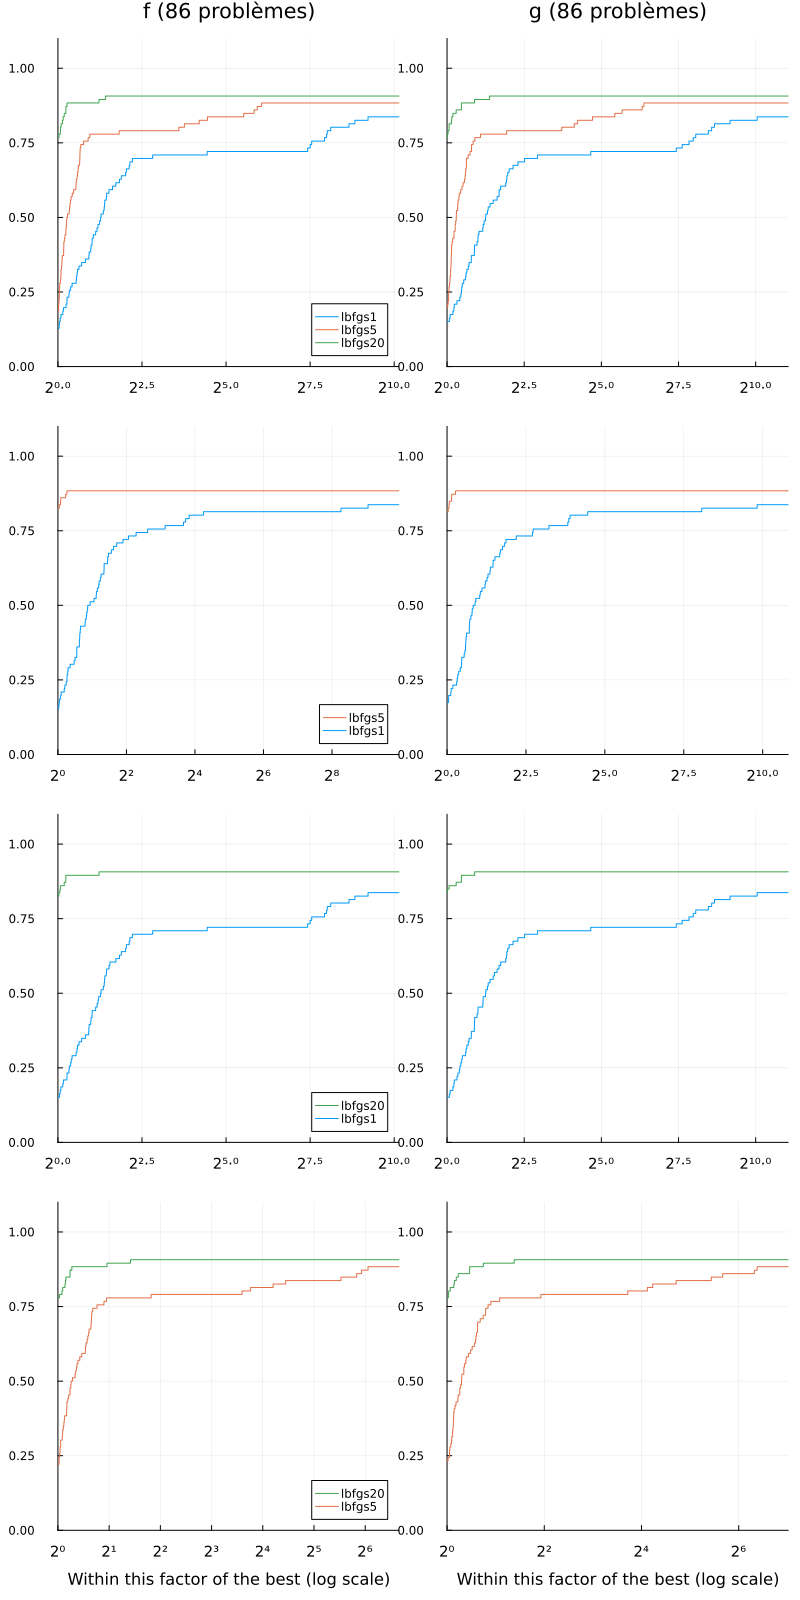

In [53]:
first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["f (86 problèmes)", "g (86 problèmes)"]
costs = [
  df -> .!solved(df) .* Inf .+ df.neval_obj,
  df -> .!solved(df) .* Inf .+ df.neval_grad,
]

using Plots
gr()

profile_solvers(stats, costs, costnames)

## Exercice 4

In [44]:
using JSOSolvers, NLPModels, NLPModelsJuMP, OptimizationProblems, OptimizationProblems.PureJuMP, SolverBenchmark

In [46]:
problems = (MathOptNLPModel(eval(Meta.parse(problem))(), name=problem) for problem ∈ OptimizationProblems.meta[!, :name])

solvers_2 = Dict(
  :lbfgs20 => model -> limited_bfgs(model, mem=20),
  :newtonCG => model -> armijo_Newton_cg(model)
)

Dict{Symbol, Function} with 2 entries:
  :newtonCG => #98
  :lbfgs20  => #97

In [47]:
stats_2 = bmark_solvers(
  solvers_2, problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 100 || get_nvar(prob) < 5),
)

┌ Warning: NZF1: number of variables adjusted to be divisible by 13 and ≥ 26
└ @ OptimizationProblems.PureJuMP C:\Users\Goglu\.julia\packages\OptimizationProblems\kFBID\src\PureJuMP\NZF1.jl:10
[ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
[ Info:            NZF1      91       0      first_order   1.0e+00   2.1e+04   1.5e-07   0.0e+00
[ Info:         arglina     100       0      first_order   2.0e-03   1.0e+02   1.6e-14   0.0e+00
[ Info:         arglinb     100       0      first_order   7.0e-03   5.0e+01   3.9e-03   0.0e+00
[ Info:         arglinc     100       0      first_order   1.0e-02   5.1e+01   3.9e-03   0.0e+00
[ Info:         arwhead     100       0      first_order   0.0e+00   0.0e+00   3.6e-08   0.0e+00
[ Info:         bdqrtic     100       0      first_order   1.6e-02   3.8e+02   1.3e-05   0.0e+00
[ Info:          biggs6       6       0        unbounded   1.0e-03      -Inf       Inf   0.0e+00
[ Info:        broydn7d     1

Dict{Symbol, DataFrames.DataFrame} with 2 entries:
  :newtonCG => 86×39 DataFrame…
  :lbfgs20  => 86×39 DataFrame…

Tel que mentionné à l'exercice 3, la meilleure variante de l'algorithme LBFGS est celle avec m=20. En effet, pour plus de 75% des problèmes, il s'agit de la variante convergent vers un résultat optimal avec le moins d'évaluations de f et g. De plus, il s'agit de la variante permettant de résoudre la plus grande quantité de problèmes.

L'algorithme Newton-CG parvient à un résultat optimal pour toutes les fonctions, sauf penalty3 et scosine. (Techniquement aussi biggs6, mais c'est parce qu'elle n'est pas bornée).

In [49]:
cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)

for solver ∈ keys(solvers_2)
  pretty_stats(stats_2[solver][!, cols], hdr_override=header)
end

┌────────┬──────────────┬────────┬───────────┬───────────┬────────┬────────┬────────┬────────┬───────────┬─────────────┐
│     id │         name │      n │      f(x) │   ‖∇f(x)‖ │    # f │   # ∇f │  # ∇²f │   iter │         t │      status │
├────────┼──────────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼─────────────┤
│     25 │         NZF1 │     91 │  2.09e+04 │  1.51e-07 │     19 │     19 │      0 │     18 │  1.02e+00 │ first_order │
│     38 │      arglina │    100 │  1.00e+02 │  1.57e-14 │      2 │      2 │      0 │      1 │  2.00e-03 │ first_order │
│     39 │      arglinb │    100 │  4.96e+01 │  3.87e-03 │      2 │      2 │      0 │      1 │  7.00e-03 │ first_order │
│     40 │      arglinc │    100 │  5.11e+01 │  3.86e-03 │      2 │      2 │      0 │      1 │  1.00e-02 │ first_order │
│     41 │      arwhead │    100 │  0.00e+00 │  3.59e-08 │      7 │      7 │      0 │      6 │  0.00e+00 │ first_order │
│     43 │      bdqrtic │    100

La cellule ci-dessous permet de généner deux graphiques de performance (neval_obj et neval_grad), évalués sur 86 problèmes contenant entre 5 et 100 variables.

On remarque que la méthode Newton-CG performe mieux que LBFGS20.

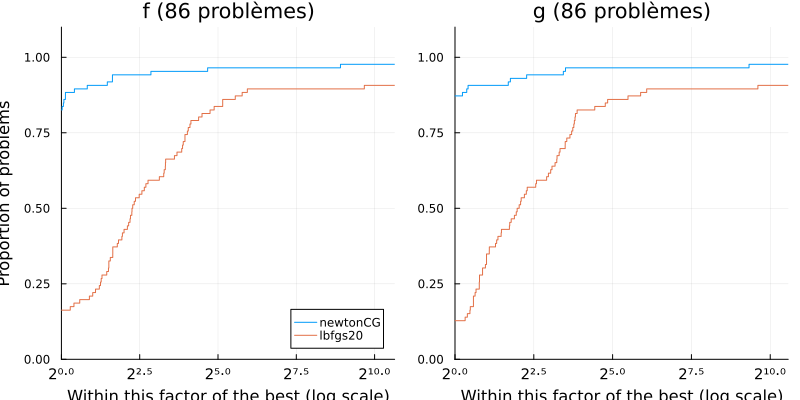

In [52]:
first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["f (86 problèmes)", "g (86 problèmes)"]
costs = [
  df -> .!solved(df) .* Inf .+ df.neval_obj,
  df -> .!solved(df) .* Inf .+ df.neval_grad,
]

using Plots
gr()

profile_solvers(stats_2, costs, costnames)